In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
cd /content/drive/My\ Drive/Kaggle/

/content/drive/My Drive/Kaggle


In [0]:
!pip -q install pydicom

In [0]:
import os
import cv2
import glob2
import pydicom
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import exposure
import sys
import shutil
from mask_functions import *

In [0]:
!unzip -q ./siim-original.zip -d /tmp/siim-original

In [0]:
test_fn = glob2.glob('/tmp/siim-original/dicom-images-test/**/*.dcm')
train_fn = glob2.glob('/tmp/siim-original/dicom-images-train/**/*.dcm')

os.mkdir('/tmp/siim-original/train/')
for full_fn in test_fn:
  fn = full_fn.split('/')[-1]
  shutil.move(full_fn,os.path.join('/tmp/siim-original/train/',fn))

for full_fn in train_fn:
  fn = full_fn.split('/')[-1]
  shutil.move(full_fn,os.path.join('/tmp/siim-original/train/',fn))

shutil.rmtree('/tmp/siim-original/dicom-images-train/')
shutil.rmtree('/tmp/siim-original/dicom-images-test/')

In [0]:
!unzip -q ./stage_2_images.zip -d /tmp/siim-original/test

In [0]:
sz = 1024
sz0 = 1024
PATH_TRAIN = '/tmp/siim-original/train/'
PATH_TEST = '/tmp/siim-original/test/'
train_out = 'train_{}.zip'.format(sz)
test_out = 'test_{}.zip'.format(sz)
mask_out = 'masks_{}.zip'.format(sz)
train = glob2.glob(os.path.join(PATH_TRAIN, '*.dcm'))
test = glob2.glob(os.path.join(PATH_TEST, '*.dcm'))
print(len(train))
print(len(test))

12089
3205


In [0]:
df = pd.read_csv('./stage_2_train.csv').set_index('ImageId')
idxs = set(df.index)
train_names = []
for f in train: #remove images without labels
    name = f.split('/')[-1][:-4]
    if name in idxs: train_names.append(f)

In [0]:
print(len(train_names))

12047


In [0]:
def convert_images(filename, arch_out, sz=sz):
    ds = pydicom.read_file(str(filename))
    img = ds.pixel_array
    img = cv2.resize(img, (sz, sz))
    img = exposure.equalize_adapthist(img) # contrast correction
    x_tot = img.mean() #image statistics
    x2_tot = (img**2).mean()
    img = ((img*255)).clip(0,255).astype(np.uint8)
    output = cv2.imencode('.png',img)[1]
    name = filename.split('/')[-1][:-4] + '.png'
    arch_out.writestr(name, output)
    return x_tot, x2_tot

def get_stats(stats): # get dataset statistics 
    x_tot, x2_tot = 0.0, 0.0
    for x, x2 in stats:
        x_tot += x
        x2_tot += x2
    
    img_avr =  x_tot/len(stats)
    img_std =  np.sqrt(x2_tot/len(stats) - img_avr**2)
    print('mean:',img_avr, ', std:', img_std)

> ### Write images

In [0]:
trn_stats = []
with zipfile.ZipFile(train_out, 'w') as arch:
    for fname in tqdm(train_names, total=len(train_names)):
        trn_stats.append(convert_images(fname,arch))

In [0]:
test_stats = []        
with zipfile.ZipFile(test_out, 'w') as arch:
    for fname in tqdm(test, total=len(test)):
        test_stats.append(convert_images(fname,arch))

In [0]:
get_stats(trn_stats)
get_stats(test_stats)

mean: 0.5210885638668373 , std: 0.2543071505069518
mean: 0.5192798085832812 , std: 0.25490605160873636


In [0]:
df.head()

,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819,-1
1.2.276.0.7230010.3.1.4.8323329.13666.1517875247.117800,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
1.2.276.0.7230010.3.1.4.8323329.11028.1517875229.983789,-1
1.2.276.0.7230010.3.1.4.8323329.10366.1517875223.393986,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
1.2.276.0.7230010.3.1.4.8323329.10016.1517875220.992175,592184 33 976 58 956 73 941 88 926 102 917 109...


### Write masks

In [0]:
mask_coverage = []
mask_count = 0
with zipfile.ZipFile(mask_out, 'w') as arch:
    for idx in tqdm(idxs):
        masks = df.loc[idx,'EncodedPixels']
        img = np.zeros((sz0,sz0))
        #do conversion if mask is not " -1"
        if(type(masks) != str or (type(masks) == str and masks != '-1')):
            if(type(masks) == str): masks = [masks]
            else: masks = masks.tolist()
            mask_count +=1
            for mask in masks:
                img += rle2mask(mask, sz0, sz0).T
        mask_coverage.append(img.mean())
        img = cv2.resize(img, (sz, sz))
        output = cv2.imencode('.png',img)[1]
        name = idx + '.png'
        arch.writestr(name, output)

print('mask coverage:', np.mean(mask_coverage)/255, ', mask count:', mask_count)


mask coverage: 0.003145134853724969 , mask count: 2669


### Read image

In [0]:
idx = 10
with zipfile.ZipFile(train_out, 'r') as arch:
    fname = sorted(arch.namelist())[idx]
    flags = cv2.IMREAD_GRAYSCALE
    img = cv2.imdecode(np.frombuffer(arch.read(fname), np.uint8), flags)
    
with zipfile.ZipFile(mask_out, 'r') as arch:
    fname = sorted(arch.namelist())[idx]
    flags = cv2.IMREAD_GRAYSCALE
    mask = cv2.imdecode(np.frombuffer(arch.read(fname), np.uint8), flags)
    
plt.figure()
plt.imshow(Image.fromarray(img))
plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()

FileNotFoundError: ignored

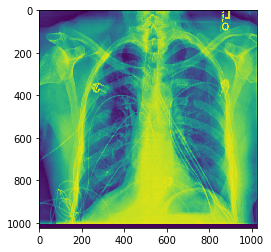

In [0]:
idx = 100
with zipfile.ZipFile('./test_1024.zip', 'r') as arch:
    fname = sorted(arch.namelist())[idx]
    flags = cv2.IMREAD_GRAYSCALE
    img = cv2.imdecode(np.frombuffer(arch.read(fname), np.uint8), flags)  
plt.figure()
plt.imshow(Image.fromarray(img))
plt.show()